# Text Analytics Final Project 

#### Praneet Solanki | Emmanuel Awa

MIND data are stored in the West/East US data center, so this notebook will run more efficiently on the Azure compute located in West/East US.

## Imports and environment

In [3]:
import os
import tempfile
import shutil
import urllib
import zipfile
import pandas as pd



# your imports may be different
import pandas as pd
import numpy as np
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from spacy.lang.en import English


In [12]:
# !python -m spacy download en_core_web_md
import en_core_web_md
nlp = en_core_web_md.load()
en = English()


In [13]:
# Temporary folder for data we need during execution of this notebook (we'll clean up
# at the end, we promise)
# temp_dir = os.path.join(tempfile.gettempdir(), 'mind')

data_folder = "mind_dataset"
temp_dir = data_folder

os.makedirs(temp_dir, exist_ok=True)


# The dataset is split into training and validation set, each with a large and small version.
# The format of the four files are the same.
# For demonstration purpose, we will use small version validation set only.
base_url = 'https://mind201910small.blob.core.windows.net/release'
training_small_url = f'{base_url}/MINDsmall_train.zip'
validation_small_url = f'{base_url}/MINDsmall_dev.zip'
training_large_url = f'{base_url}/MINDlarge_train.zip'
validation_large_url = f'{base_url}/MINDlarge_dev.zip'

## Functions

In [14]:
def download_url(url,
                 destination_filename=None,
                 progress_updater=None,
                 force_download=False,
                 verbose=True):
    """
    Download a URL to a temporary file
    """
    if not verbose:
        progress_updater = None
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        if verbose:
            print('Bypassing download of already-downloaded file {}'.format(
                os.path.basename(url)))
        return destination_filename
    if verbose:
        print('Downloading file {} to {}'.format(os.path.basename(url),
                                                 destination_filename),
              end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)
    assert (os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    if verbose:
        print('...done, {} bytes.'.format(nBytes))
    return destination_filename

## Download and extract the files

In [1]:
# For demonstration purpose, we will use small version validation set only.
# This file is about 30MB.
zip_path = download_url(validation_small_url, verbose=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

os.listdir(temp_dir)

NameError: name 'download_url' is not defined

## Read the files with pandas

In [2]:
# The news.tsv file contains the detailed information of news articles involved in the behaviors.tsv file.
# It has 7 columns, which are divided by the tab symbol:
# - News ID
# - Category
# - Subcategory
# - Title
# - Abstract
# - URL
# - Title Entities (entities contained in the title of this news)
# - Abstract Entities (entities contained in the abstract of this news)
news_path = os.path.join(temp_dir, 'news.tsv')
news = pd.read_table(news_path,
              header=None,
              names=[
                  'id', 'category', 'subcategory', 'title', 'abstract', 'url',
                  'title_entities', 'abstract_entities'
              ])

NameError: name 'os' is not defined

In [ ]:
news.head()

In [36]:
news.shape

(101527, 8)

In [37]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101527 entries, 0 to 101526
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 101527 non-null  object
 1   category           101527 non-null  object
 2   subcategory        101527 non-null  object
 3   title              101527 non-null  object
 4   abstract           96112 non-null   object
 5   url                101527 non-null  object
 6   title_entities     101524 non-null  object
 7   abstract_entities  101521 non-null  object
dtypes: object(8)
memory usage: 6.2+ MB


In [38]:
news.groupby('category').describe()

id                      subcategory         \
               count unique      top freq       count unique   
category                                                       
autos           3071   3071  N118850    1        3071     25   
entertainment    837    837  N129103    1         837     15   
finance         5916   5916   N41626    1        5916     33   
foodanddrink    4418   4418  N123842    1        4418     16   
games              1      1  N103356    1           1      1   
health          2929   2929   N44198    1        2929     23   
kids             104    104   N36288    1         104      6   
lifestyle       4570   4570    N3454    1        4570     53   
middleeast         2      2  N126389    1           2      1   
movies           815    815   N34677    1         815      7   
music           1263   1263   N23478    1        1263     11   
news           30478  30478   N98253    1       30478     38   
northamerica       1      1   N27080    1           1      1   
sports         32020  32020   N13160    1       32020     34   
travel          4955   4955  N112482    1        4955     16   
tv              1323   1323  N115704    1        1323     10   
video           4569   4569  N117943    1        4569     15   
weather         4255   4255  N109862    1        4255      3   

                                              title         ...  \
                                  top   freq  count unique  ...   
category                                                    ...   
autos                       autosnews   1703   3071   3027  ...   
entertainment                  gaming    256    837    828  ...   
finance                   financenews   1932   5916   5814  ...   
foodanddrink               newstrends   2714   4418   4354  ...   
games                      games-news      1      1      1  ...   
health                        medical    954   2929   2901  ...   
kids                    people-places     24    104    104  ...   
lifestyle               lifestylebuzz   1944   4570   4487  ...   
middleeast     middleeast-top-stories      2      2      2  ...   
movies                      movienews    406    815    811  ...   
music                       musicnews    874   1263   1251  ...   
news                           newsus  14467  30478  29678  ...   
northamerica       northamerica-video      1      1      1  ...   
sports                   football_nfl  11813  32020  30756  ...   
travel                  travelarticle   2624   4955   4883  ...   
tv                             tvnews    777   1323   1316  ...   
video                            news   3316   4569   4499  ...   
weather             weathertopstories   4253   4255   4019  ...   

                                                         url       \
                                                         top freq   
category                                                            
autos          https://assets.msn.com/labs/mind/AAJfUTH.html    1   
entertainment  https://assets.msn.com/labs/mind/AAJWGjg.html    1   
finance        https://assets.msn.com/labs/mind/AAJaw8n.html    1   
foodanddrink   https://assets.msn.com/labs/mind/AAJarNQ.html    1   
games          https://assets.msn.com/labs/mind/AAJhv8W.html    1   
health         https://assets.msn.com/labs/mind/BBWqy1w.html    1   
kids           https://assets.msn.com/labs/mind/AAJQ33i.html    1   
lifestyle      https://assets.msn.com/labs/mind/AAJhtEh.html    1   
middleeast     https://assets.msn.com/labs/mind/AAJsYXt.html    1   
movies         https://assets.msn.com/labs/mind/BBWAnZ9.html    1   
music          https://assets.msn.com/labs/mind/AAIzX0r.html    1   
news           https://assets.msn.com/labs/mind/BBWynxl.html    1   
northamerica   https://assets.msn.com/labs/mind/BBWFdBy.html    1   
sports         https://assets.msn.com/labs/mind/BBWwaeF.html    1   
travel         https://assets.msn.com/labs/mind/AAIF58L.html    1   
tv             https://

In [39]:
category_list = list(news.category.unique())
print(len(category_list))
category_list

18


['lifestyle',
 'news',
 'health',
 'sports',
 'weather',
 'entertainment',
 'foodanddrink',
 'autos',
 'travel',
 'video',
 'finance',
 'tv',
 'movies',
 'music',
 'kids',
 'middleeast',
 'games',
 'northamerica']

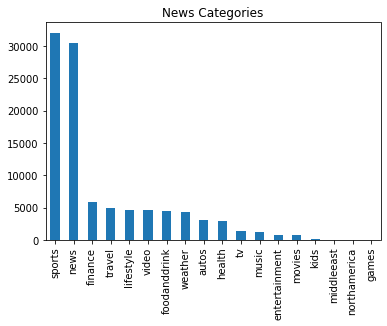

In [40]:
# Distribution of the categories
news.category.value_counts().plot.bar(title="News Categories");

## Tokenizer

In [41]:
# Defining a tokenizer 
# Pipeline to remove stop words, urls, punct and lammatize words

def better_tokenizer(doc, model=en):
  return [x.lemma_.lower() for x in en(doc) if (x.is_alpha)&
          (not x.like_url)&(not x.is_punct)&(not x.is_stop)]

## Split dataset in train, val, test

In [42]:
pct_train = 0.7
pct_val = 0.3
train_bool = np.random.random(len(news))<=pct_train
train = news[train_bool]
test = news[~train_bool]
val_bool = np.random.random(size=len(train))<=pct_val
val = train[val_bool]
train = train[~val_bool]

In [43]:
# Creating tokenized representation 
all_data = [better_tokenizer(str(d)) for d in (news['title']+news['abstract'])]

In [44]:
all_data[0]

['brands',
 'queen',
 'elizabeth',
 'prince',
 'charles',
 'prince',
 'philip',
 'swear',
 'byshop',
 'notebooks',
 'jackets',
 'royals',
 'live']

In [45]:
# this formulation works if you have previously tokenized
cv = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False,min_df=2) # min_df=0.001, max_df=0.9)
tfidf = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False,min_df=2)#min_df=0.001, max_df=0.9)

In [46]:
# **important** just fit on trained: prevents information from test in training 
cv_vecs = cv.fit_transform(all_data).toarray()
tfidf_vecs = tfidf.fit_transform(all_data).toarray()


# get out the vocab (same for tfidf)
vocab = cv.vocabulary_
print("Size of vocab:", len(vocab))

Size of vocab: 49443


In [47]:
tfidf_vecs.shape

(101527, 49443)

### Top words for each news category articles (Counts and TF-IDF)

In [48]:
# get top x words
top_words = 10


# Getting the correct index for rows in the train dataset. The original index are kept intact and not reset.

categories_rows_indx = []

for category in category_list:
    categories_rows_indx.append((category, news.index[news['category'] == category].tolist()))


In [49]:
# fcategory_list[:4]
# categories_rows_indx[0]

In [50]:
for vectorizer, vecs  in [(cv, cv_vecs), (tfidf, tfidf_vecs)]:
    for category, indx in categories_rows_indx:    
        # sum counts
        s_sum = vecs[indx].sum(axis=0)
        # sort arguments
        s_sorted = np.argsort(s_sum)
        # print top words
        print(f"Top {top_words} words using {vectorizer.__class__.__name__} for {category} category")
        print([vectorizer.get_feature_names()[x] for x in s_sorted[-top_words:]])
        print("\n")

Top 10 words using CountVectorizer for lifestyle category
['best', 'day', 'time', 'halloween', 'family', 'old', 'school', 'said', 'home', 'new']


Top 10 words using CountVectorizer for news category
['state', 'school', 'old', 'city', 'county', 'man', 'new', 'trump', 'said', 'police']


Top 10 words using CountVectorizer for health category
['study', 'medical', 'flu', 'weight', 'vaping', 'people', 'said', 'cancer', 'new', 'health']


Top 10 words using CountVectorizer for sports category
['sunday', 'night', 'state', 'new', 'win', 'football', 'team', 'week', 'season', 'game']


Top 10 words using CountVectorizer for weather category
['cold', 'power', 'morning', 'area', 'forecast', 'storm', 'said', 'snow', 'fire', 'weather']


Top 10 words using CountVectorizer for entertainment category
['halloween', 'plus', 'week', 'xbox', 'celebrity', 'best', 'stars', 'games', 'game', 'new']


Top 10 words using CountVectorizer for foodanddrink category
['open', 'day', 'home', 'recipes', 'restaurants'

In [ ]:
n_components=10

nmf = NMF(n_components=n_components)
lda = LatentDirichletAllocation(n_components=n_components)

# tfidf for nmf
nmf_vecs = nmf.fit_transform(tfidf_vecs)
# count for lda
lda_vecs = lda.fit_transform(cv_vecs)

In [ ]:
# topic model performance
print('NMF Reconstruction err:', nmf.reconstruction_err_)
print('LDA ELBO:', lda.bound_)

In [48]:
# Topic model top 10 words
def display_components(model, word_features, top_display=8):
    # utility for displaying respresentative words per component for topic models
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        top_words_idx = topic.argsort()[::-1][:top_display]
        top_words = [word_features[i] for i in top_words_idx]
        print(" ".join(top_words))

In [ ]:
print('Displaying top 10 words in each topic using NMF(tfidf): ')
display_components(nmf, tfidf.get_feature_names())

print('\n')

print('Displaying top 10 words in each topic using LDA(CountVectorizer): ')
display_components(lda, cv.get_feature_names())

In [8]:
# # The entity_embedding.vec file contains the 100-dimensional embeddings
# # of the entities learned from the subgraph by TransE method.
# # The first column is the ID of entity, and the other columns are the embedding vector values.
# entity_embedding_path = os.path.join(temp_dir, 'entity_embedding.vec')
# entity_embedding = pd.read_table(entity_embedding_path, header=None)
# entity_embedding['vector'] = entity_embedding.iloc[:, 1:101].values.tolist()
# entity_embedding = entity_embedding[[0,
#                                      'vector']].rename(columns={0: "entity"})
# entity_embedding

In [9]:
# # The relation_embedding.vec file contains the 100-dimensional embeddings
# # of the relations learned from the subgraph by TransE method.
# # The first column is the ID of relation, and the other columns are the embedding vector values.
# relation_embedding_path = os.path.join(temp_dir, 'relation_embedding.vec')
# relation_embedding = pd.read_table(relation_embedding_path, header=None)
# relation_embedding['vector'] = relation_embedding.iloc[:,
#                                                        1:101].values.tolist()
# relation_embedding = relation_embedding[[0, 'vector'
#                                          ]].rename(columns={0: "relation"})
# relation_embedding

## Clean up temporary files

In [10]:
# shutil.rmtree(temp_dir)